In [1]:
## IMPORTING LIBRARIES

import traitlets
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from numpy import genfromtxt
import math
from tkinter import Tk, filedialog
from ipywidgets import *
from IPython.display import clear_output, display, Javascript
from IPython.core.display import display, HTML

import pytesseract
import cv2
import re

from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion

from lmfit.models import LinearModel, LorentzianModel, QuadraticModel
from mpl_toolkits import mplot3d
from scipy.optimize import curve_fit
from lmfit import Model
import statistics
from statistics import stdev
from scipy.signal import find_peaks

import photutils
#import astropy.tablep

%matplotlib inline

In [2]:
## FUNCTIONS:

# Function for creating select files dialogue
def select_files(b):
    root = Tk()
    root.withdraw()                                        # Hide the main window
    root.call('wm', 'attributes', '.', '-topmost', True)   # Raise the root to the top of all windows.
    b.files = filedialog.askopenfilename(multiple=True)    # List of selected fileswill be set to b.value
    f = b.files
    b.description = "Files Selected"
    b.icon = "check-square-o"
    b.style.button_color = "lightgreen"
    #clear_output()
    # Adding the dot variable helps you access the variable value outside the function.
    select_files.selectfs = SelectMultiple(options=f, value=[f[0]], disabled=False, layout=Layout(width='100%', height='300px'))
    print("Selected files:")
    display(select_files.selectfs) 

In [3]:
# Function for peak detection

def detect_peaks(image):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    neighborhood = generate_binary_structure(3,3)

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.

    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background

    return detected_peaks

In [4]:
# Function 2 for peak detection

def peak2d(array):
    '''This function finds the peak in a 2D array by the
       recursive method.

       Complexity: O(n log m)'''

    n = len(array)
    m = len(array[0])

    j = m//2

    row = [i[j] for i in array]

    i = row.index(max(row))

    print(i, j)

    if j > 0 and array[i][j] < array[i][j-1]:
        return peak2d([row[:j] for row in array])

    elif j < m - 1 and array[i][j] < array[i][j+1]:
        return peak2d([row[j:] for row in array])

    else:
        return i,j,array[i][j]

In [5]:
# Function for distance calculation

def dist_calc(x,y,peak_x,peak_y):
    
    return np.sqrt((x-peak_x)**2 + (y-peak_y)**2)

In [6]:
def ang_calc(x,y,dist,i,j,peak_x,peak_y):
    
    rel_x = x-peak_x
    rel_y = y-peak_y
    
    num = rel_x[i]*rel_x[j] + rel_y[i]*rel_y[j]
    den = dist[i]*dist[j]
    frac = num/den
    
    return math.degrees(np.arccos(frac))
    

In [7]:
# Function for gaussian fitting 

def gaussian_2d(xy_mesh, offset, amp, xc, yc, sigma_x, sigma_y):
    
    # unpack 1D list into 2D x and y coords
    (x, y) = xy_mesh
    
    # make the 2D Gaussian matrix
    gauss = offset+(amp*np.exp(-((x-xc)**2/(2*sigma_x**2)+(y-yc)**2/(2*sigma_y**2)))/(2*np.pi*sigma_x*sigma_y))
    
    # flatten the 2D Gaussian down to 1D
    return np.ravel(gauss)

In [8]:
# Function for radial integration

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

In [9]:
def stackImages(scale,imgArray):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape [:2]:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv2.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None,scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        ver = hor
    return ver

In [10]:
def empty(a):
    pass

In [11]:
    # Open file(s)
    ################################################################################
    
    fileselect = Button(description="File Select")
    fileselect.icon = "square-o"
    fileselect.style.button_color = "orange"
    fileselect.on_click(select_files)


    display(fileselect)
    
    ################################################################################

Button(description='File Select', icon='square-o', style=ButtonStyle(button_color='orange'))

Selected files:


SelectMultiple(index=(0,), layout=Layout(height='300px', width='100%'), options=('C:/Users/Student User/OneDri…

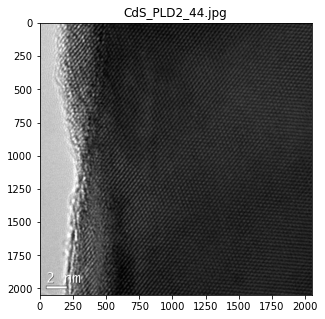

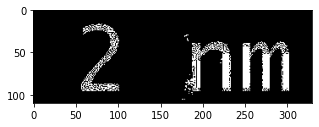

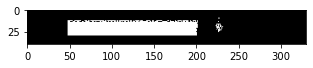

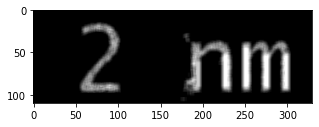

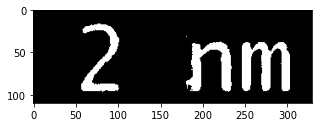

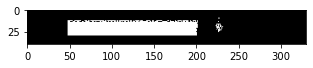

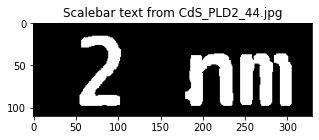

Text detected: 2 nn


Number separated: 2.0
Unit found:  nn




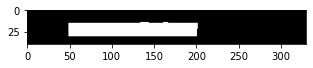

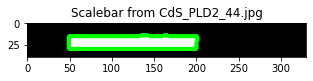

Pixel length: 152 	 Scale: 2.0
Calibration: 76.00000 pixel/ nn


_________________________________________________________________________________________________


In [12]:
# Copy the information from file
################################################################################

f = select_files.selectfs.value
fnames = [None] * len(f)
scalenos = np.zeros(len(f))
scaleunits = [None] * len(f)
calibs = np.zeros(len(f))

################################################################################


# Plotting the image and obtaining sacle bar text and length
################################################################################

for i in range(0,len(f)):
    plt.rcParams['figure.figsize'] = [5, 5]

    fx = select_files.selectfs.value[i]
    head, tail = os.path.split(fx)
    fnames[i] = tail

    imgsr = (cv2.imread(fx)) ## Why the brackets?
    #cv2.imwrite("out.jpeg", imgsr)
    #imgsr = (cv2.imread("out.jpeg"))
    plt.imshow(imgsr)
    plt.title(tail)
    plt.show()

    imgsr[imgsr<255]=0
    imgscaletxt = imgsr[1860:1970,0:330]
    imgscale = imgsr[1970:2010,0:330]
    plt.imshow(imgscaletxt)
    plt.show()
    plt.imshow(imgscale)
    plt.show()
    blur = cv2.blur(imgscaletxt,(5,5))
    plt.imshow(blur)
    plt.show()
    ret, thresh = cv2.threshold(blur, 75, 255, 0) #threhold setting to an image with a max. value for all elements with the value higher than a given threshold

    plt.imshow(thresh)
    plt.show()
    plt.imshow(imgscale)
    plt.show()
    kernel = np.ones((5, 5), np.uint8)

    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    #imgscale = cv2.morphologyEx(imgscale, cv2.MORPH_OPEN, kernel)

    txteroded = cv2.erode(thresh, kernel, iterations = 1)
    txtdilated = cv2.dilate(txteroded, kernel, iterations = 1)
    txteroded = cv2.erode(txtdilated, kernel, iterations = 1)
    txtdilated = cv2.dilate(txteroded, kernel, iterations = 1)
    txteroded = cv2.erode(txtdilated, kernel, iterations = 1)
    txtdilated = cv2.dilate(txteroded, kernel, iterations = 1)
    txteroded = cv2.erode(txtdilated, kernel, iterations = 1)
    txtdilated = cv2.dilate(txtdilated, kernel, iterations = 1)


    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract.exe'
    custom_config = r'--oem 3 --psm 11'
    #custom_config = ('-l eng --oem 1 --psm 3')
    scalestring = pytesseract.image_to_string(txtdilated, config=custom_config)
    plt.imshow(txtdilated)
    plt.title("Scalebar text from {}".format(tail))
    plt.show()


    print('Text detected:',scalestring)
    scalelen = (re.findall('\d*\.?\d+',scalestring)[0])
    scalenos[i] = scalelen
    print('Number separated:', float(scalelen))
    scaleunit = scalestring.replace(scalelen,'')
    scaleunits[i] = scaleunit
    print('Unit found:',scaleunit)

    eroded = cv2.erode(imgscale, kernel, iterations = 1)
    dilated = cv2.dilate(eroded, kernel, iterations = 1)
    kernel_2 = np.ones((6, 6), np.uint8)
    dilated = cv2.erode(dilated,  kernel_2, iterations=1)
    dilated = cv2.dilate(dilated, kernel_2, iterations = 1)

    plt.imshow(dilated)
    plt.show()

    imgray = cv2.cvtColor(dilated, cv2.COLOR_BGR2GRAY)
    #imgray = cv2.GaussianBlur(imgray, (9, 9), 0)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #print(contours)
    drawn = cv2.drawContours(dilated, contours, -1, (0,255,0), 3)
    plt.imshow(drawn)
    plt.title("Scalebar from {}".format(tail))
    plt.show()

    pixmin = np.max(contours[0][:,0,0])
    pixmax = np.min(contours[0][:,0,0])
    pixlen = abs(pixmax-pixmin)

    print('Pixel length:',pixlen,'\t Scale:',float(scalelen))
    calib = pixlen/float(scalelen)
    calibs[i] = calib
    print("Calibration: {:.5f} pixel/{}".format(calib, scaleunit))
    print('_________________________________________________________________________________________________')

############################################################


In [13]:
plt.rcParams['figure.figsize'] = [15, 15]

prev_scale = 0.3
kernel_sideraw = 200
kernel_side = kernel_sideraw*prev_scale
ksize = 200

Npx = ksize
perpix = calibs/Npx
print(perpix)

prev_locations = []
img_locations = []
counter = 0

f = fileselect.files
img = cv2.imread(f[0])
rawsize = np.shape(img)
print("File: ", f[0])
print("Raw size: ", rawsize)

imprev = cv2.resize(img, (int(rawsize[0]*prev_scale), int(rawsize[1]*prev_scale)))                    # Resize image
prevsize = np.shape(imprev)
print("Preview size: ", prevsize)

xx = np.linspace(0,ksize,ksize)
yy = np.linspace(0,ksize,ksize)
X,Y = np.meshgrid(xx,yy)

head,tail = os.path.split(f[0])

[0.38]
File:  C:/Users/Student User/OneDrive - UW/Research/Prof Peter/TEM Analysis/CdS_PLD2_44.jpg
Raw size:  (2048, 2048, 3)
Preview size:  (614, 614, 3)


In [66]:
def method_peak_detection(fit_residual,x,y):
    
    peak_x,peak_y,peak_intes = peak2d(fit_residual)
    #print(fit_residual.shape)
    #plt.imshow(fit_residual)
    #fit_residual = cv2.cvtColor(fit_residual,cv2.COLOR_BGR2GRAY)
    #cv2.imshow("Image final",fit_residual)

    cv2.namedWindow("Peak Finding")
    cv2.resizeWindow("Peak Finding",640,100)
    cv2.createTrackbar("Threshold","Peak Finding",100,200,empty)
    cv2.createTrackbar("Box Size","Peak Finding",3,5,empty)
    #cv2.createTrackbar("Threshold","Peak Finding",50,200,empty)

    while(1):
        #cv2.imshow("Residual",cv2.cvtColor(fit_residual,cv2.COLOR_RGB2BGR))

        # get current positions of four trackbars
        threshold = cv2.getTrackbarPos("Threshold","Peak Finding")
        box_sz = cv2.getTrackbarPos("Box Size","Peak Finding")

        #mag_gray = cv2.cvtColor(fit_residual, cv2.COLOR_BGR2GRAY)
        detected_peaks = photutils.detection.find_peaks(fit_residual,threshold,box_size=(box_sz,box_sz))
        #print(detected_peaks)
        #print(detected_peaks.colnames)
        #detected_peaks = detected_peaks.remove_columns(['y_peak','peak_value'])
        detected_peaks = detected_peaks.as_array()
        #print(detected_peaks)
        lenp = len(detected_peaks)

        xval = np.zeros(shape=(lenp),dtype=np.float64)
        yval = np.zeros(shape=(lenp),dtype=np.float64)
        intes = np.zeros(shape=(lenp),dtype=np.float64)
        dist = np.zeros(shape=(lenp),dtype=np.float64)
        dist_cal = np.zeros(shape=(lenp),dtype=np.float64)
        invdis = np.zeros(shape=(lenp),dtype=np.float64)
        resp_intes = np.zeros(shape=(lenp),dtype=np.float64)
        ang = np.zeros(shape=(lenp,lenp),dtype=np.float64)
        
        # d-spacing calculation
        for i in range(np.shape(detected_peaks)[0]):
            xval[i] = detected_peaks[i][0]
            yval[i] = detected_peaks[i][1]
            intes[i] = detected_peaks[i][2]
            dist[i] = dist_calc(xval[i],yval[i],peak_x,peak_y)
            dist_cal[i] = dist[i]*perpix
            resp_intes[i] = np.abs(peak_intes - intes[i])
            invdis[i]=1/dist_cal[i] ## d-spacing
        
        # Angle Calculation
        for i in range(len(xval)):
            for j in range(len(yval)):
                ang[i,j] = ang_calc(xval,yval,dist,i,j,peak_x,peak_y)
                
        #print(ang[0])

        for i in range(len(invdis)):
            if invdis[i] < 0.2:
                cv2.circle(imprev, (x,y), 10, (200,100,90), cv2.FILLED) #BGR
                break
            else:
                cv2.circle(imprev, (x,y), 10, (0,255,0), cv2.FILLED)
                break
                
        index_file_path = str('CdS_index.csv')
        index_data = genfromtxt(index_file_path, delimiter=',')
                
        fig_p, (axs1,axs2) = plt.subplots(1,2)
        axs1.plot(4,2,(2*i+1))
        axs1.imshow(fit_residual,cmap='gray')
        axs2.plot(4,2,(2*i+2) )
        axs2.imshow(fit_residual,cmap='gray')
        axs2.scatter(xval,yval,color='r')
        for i in range(len(xval)):
            axs2.arrow(peak_x,peak_y,(xval[i]-peak_x),(yval[i]-peak_y),color='b',linewidth=2)

        fig_p.canvas.draw()

        img_p = np.fromstring(fig_p.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img_p  = img_p.reshape(fig_p.canvas.get_width_height()[::-1] + (3,))

        # img is rgb, convert to opencv's default bgr
        img_p = cv2.cvtColor(img_p,cv2.COLOR_RGB2BGR)
        #print(img_p.shape)
        
        #cv2.arrowedLine(img_p, (peak_x,pea), end_point, color, thickness)

        # display image with opencv or any operation you like
        #cv2.circle(img_p, (xval,yval), 10, (255,255,0), cv2.FILLED)
        cv2.imshow("Final Peak",img_p)
                                
        d_spacing_A = np.array(index_data[1:,0])
        i_h = np.array(index_data[1:,1])
        i_k = np.array(index_data[1:,2])
        i_l = np.array(index_data[1:,3])
        
        d_diff = np.zeros(shape=(len(invdis),len(d_spacing_A)),dtype=np.float64)
        p_d_used = np.zeros(shape=(len(invdis)),dtype=np.float64)
        p_d_diff = np.zeros(shape=(len(invdis)),dtype=np.float64)
        p_h = np.zeros(shape=(len(invdis)),dtype=np.int32)
        p_k = np.zeros(shape=(len(invdis)),dtype=np.int32)
        p_l = np.zeros(shape=(len(invdis)),dtype=np.int32)
        p_ind = np.zeros(shape=(len(invdis),3),dtype=np.int32)
        
        for i in range(len(invdis)):
            d_diff[i,:] = abs(10*invdis[i]-d_spacing_A)
            #print(d_diff[i,:])
            i_min = np.argmin(d_diff[i,:])
            #print(i_min)
            p_d_used[i] = d_spacing_A[i_min]
            p_d_diff[i] = d_diff[i,i_min]
            #print(p_d_diff)
            p_h[i] = i_h[i_min]
            p_k[i] = i_k[i_min]
            p_l[i] = i_l[i_min]
            p_ind[i] = [p_h[i],p_k[i],p_l[i]]
            
        for i in range (len(p_ind)):
            for j in range(len(p_ind)):
                if all(p_ind[i] == p_ind[j]):
                    pass
                else:
                    za = np.cross(p_ind[i],p_ind[j])
                    print(za)
        result_data = np.zeros(shape=(1+len(invdis),6))
        #result_data[0][0] = "Zone-axis"
        result_data[0,:3] = za[:]
        
        for i in range(len(invdis)):
            result_data[i+1][0] = 10*invdis[i]
            result_data[i+1][1] = p_d_used[i]
            result_data[i+1][2] = p_d_diff[i]
            result_data[i+1][3] = p_h[i]
            result_data[i+1][4] = p_k[i]
            result_data[i+1][5] = p_l[i]
            
        np.savetxt("Result-"+str(counter)+".csv",result_data,delimiter=',')
        
        with open("Result_"+str(counter)+".txt",'w') as f:
            f.write("d-spacing (nm)")
            for i in range(len(invdis)):
                f.write("\n"+str(10*invdis[i])+"   "+str(p_d_used[i])+"   "+str(p_d_diff[i])+"   "+str(p_h[i])+"   "+str(p_k[i])+"   "+str(p_l[i]))
            f.write("\nAngles between peaks")
            for i in range(len(ang)):
                f.write("\n"+str(ang[i,0]))
            #for i in range(len(d_diff[0])):

        k = cv2.waitKey(33) & 0xFF
        if k == 27:
            break

    cv2.destroyWindow("Peak Finding")
    cv2.destroyWindow("Final Peak")
    
    pass
        

In [15]:
def method_radial_integration(magnitude_spectrum,x,y):
    #profile = radial_profile(np.log(1+np.abs(magnitude_spectrum)),(ksize/2,ksize/2))
    profile = radial_profile(magnitude_spectrum,(ksize/2,ksize/2))
    
    # Adjust the st and en values from the x axis above to surround the lorentz peak
    cv2.namedWindow("Integration")
    cv2.resizeWindow("Integration",640,100)
    cv2.createTrackbar("Start","Integration",7,20,empty)
    cv2.createTrackbar("End","Integration",15,50,empty)
    #cv2.createTrackbar("Threshold","Peak Finding",50,200,empty)

    while(1):
        uncalibx = np.linspace(0,len(profile),len(profile))

        st = 0  # Adjust st to cut the radial profile at the start to remove the zero line
        #profile = radial_profile(np.log(1+np.abs(maskedfft)),(ksize/2,ksize/2))
        fig_mrl = plt.figure()
        plt.plot(uncalibx, profile[st:])

        fig_mrl.canvas.draw()

        img_mrl = np.fromstring(fig_mrl.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img_mrl  = img_mrl.reshape(fig_mrl.canvas.get_width_height()[::-1] + (3,))

        # img is rgb, convert to opencv's default bgr
        img_mrl = cv2.cvtColor(img_mrl,cv2.COLOR_RGB2BGR)
        #print(img_p.shape)

        # display image with opencv or any operation you like
        #cv2.circle(img_p, (xval,yval), 10, (255,255,0), cv2.FILLED)
        #cv2.imshow("Complete Radial Integration",img_mrl)
        #cv2.imshow("Residual",cv2.cvtColor(fit_residual,cv2.COLOR_RGB2BGR))

        # get current positions of four trackbars
        st = cv2.getTrackbarPos("Start","Integration")
        en = cv2.getTrackbarPos("End","Integration")
        
        invspace = np.linspace(0,len(profile),len(profile))*perpix
        xdata, ydata = invspace[st:en], profile[st:en]

        mod = LorentzianModel()+LinearModel()
        print(mod.param_names)
        pars = mod.make_params(amplitude=150, center=3.8, sigma=1, slope=1, intercept=160)
        init = mod.eval(pars, x=xdata)
        out = mod.fit(ydata, pars, x=xdata)
        print(out.fit_report(min_correl=0.5))

        fig_rl = plt.figure()
        ax1 = fig_rl.add_subplot(1,1,1)
        #ax1.set_title(tail+" - "+txt)
        ax1.scatter(xdata, ydata)
        ax1.plot(xdata, out.best_fit, 'r-')
        #plt.show()
        
        fig_rl.canvas.draw()

        img_rl = np.fromstring(fig_rl.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img_rl = img_rl.reshape(fig_rl.canvas.get_width_height()[::-1] + (3,))

        # img is rgb, convert to opencv's default bgr
        img_rl = cv2.cvtColor(img_rl,cv2.COLOR_RGB2BGR)
        #print(img_p.shape)

        # display image with opencv or any operation you like
        #cv2.circle(img_p, (xval,yval), 10, (255,255,0), cv2.FILLED)
        #cv2.imshow("Radial Integration",img_rl)
        imgStack = stackImages(0.7,([img_mrl,img_rl]))
 
        # imgHor = np.hstack((img,img))
        # imgVer = np.vstack((img,img))
        #
        # cv2.imshow("Horizontal",imgHor)
        # cv2.imshow("Vertical",imgVer)
        cv2.imshow("Final Integration",imgStack)
        
        k = cv2.waitKey(1)
        if k == 27:
            break
            
    print(1/out.best_values['center'])
            
    if 1/out.best_values['center'] < 0.2:
        cv2.circle(imprev, (x,y), 10, (200,100,90), cv2.FILLED)
    else:
        cv2.circle(imprev, (x,y), 10, (0,255,0), cv2.FILLED)
            
    #cv2.destroyWindow("Compelte Radial Integration")
    #cv2.destroyWindow("Radial Integration")
    cv2.destroyWindow("Final Integration")
    cv2.destroyWindow("Integration")
    
    pass

In [16]:
def mousepoint(event, x, y, flags, params):
    global counter
    if event == cv2.EVENT_LBUTTONDOWN and x>int(kernel_side/2) and y>int(kernel_side/2) and x<int(prevsize[0]-kernel_side/2) and y<int(prevsize[0]-kernel_side/2):
        counter = counter+1
        print("Preview location {}: {}, {}".format(counter,x,y))
        prev_locations.append([x,y])
        img_locations.append([int(x/prev_scale),int(y/prev_scale)])
        cv2.circle(imprev, (x,y), 2, (255,0,0), cv2.FILLED)
        txt = "A"+str(counter)
        cv2.putText(imprev,txt, (x+5,y+3), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(255,255,255),1)
        cv2.rectangle(imprev, (int(x-kernel_side/2),int(y-kernel_side/2)), (int(x+kernel_side/2),int(y+kernel_side/2)), (255,0,0), 1)
        cv2.imshow(tail, imprev)
        
        imcut = img[int(y/prev_scale-kernel_sideraw/2):int(y/prev_scale+kernel_sideraw/2),int(x/prev_scale-kernel_sideraw/2):int(x/prev_scale+kernel_sideraw/2)]
        imcut = cv2.cvtColor(imcut,cv2.COLOR_BGR2GRAY)
        #fft = np.fft.fft2(imcut)
        #magnitude_spectrum = np.fft.fftshift(fft)
        
        fft = np.fft.fft2(imcut)
        fshift = np.fft.fftshift(fft)
        magnitude_spectrum = 20*np.log(np.abs(fshift))
        #cv2.imread(magnitude_spectrum)
        #cv2.imshow("Residual",magnitude_spectrum)
        #magnitude_spectrum = cv2.UMat(magnitude_spectrum)
        
        fig_3 = plt.figure()
        ax = fig_3.add_subplot(1, 1, 1)
        ax = plt.axes(projection='3d')
        ax.plot_surface(X, Y, magnitude_spectrum, cmap='viridis', edgecolor='none')
        ax.view_init(0, 90)
        #plt.show()
        fig_3.canvas.draw()
        
        img_1 = np.fromstring(fig_3.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img_1  = img_1.reshape(fig_3.canvas.get_width_height()[::-1] + (3,))

        # img is rgb, convert to opencv's default bgr
        img_1 = cv2.cvtColor(img_1,cv2.COLOR_RGB2BGR)

        # display image with opencv or any operation you like
        cv2.imshow("Spectrum",img_1)
        #cv2.resize(cv2.UMat(img_1),(480,480))
        #cv2.resizeWindow("3D-plot",480,480)
        
        cv2.namedWindow("Parameter Adjustment")
        cv2.resizeWindow("Parameter Adjustment",640,80)
        cv2.createTrackbar("Offset","Parameter Adjustment",100,200,empty)
        cv2.createTrackbar("Amplitude","Parameter Adjustment",35,50,empty)
        
        while(1):
            #cv2.imshow("3D-plot",img_1)
            # get current positions of four trackbars
            offset = cv2.getTrackbarPos("Offset","Parameter Adjustment")
            amp = cv2.getTrackbarPos("Amplitude","Parameter Adjustment")
            
            k = cv2.waitKey(1) & 0xFF
            if k == 27:
                break
                
            #print(offset)
            
        cv2.destroyWindow("Parameter Adjustment")
        cv2.destroyWindow("Spectrum")
        
        #print("Offset = " + str(offset))
        #print("Amplitude = " + str(amp))
            
        #ax = plt.axes(projection='3d')
        #ax.plot_surface(X, Y, magnitude_spectrum, cmap='viridis', edgecolor='none')
        #ax.view_init(0, 90)
        #plt.show()
        #cv2.imshow("Spectra",magnitude_spectrum)
        
        # set initial parameters to build mock data
        #offset = 110
        #amp = 35
        
        xc, yc = np.median(xx), np.median(yy)
        #xc, yc = 40,40
        sigma_x, sigma_y = xx[-1]/2 , yy[-1]/2

        # define some initial guess values for the fit routine
        guess_vals = [offset, amp*2, xc*0.8, yc*0.8, sigma_x/1.5, sigma_y/1.5]

        # perform the fit, making sure to flatten the noisy data for the fit routine 
        fit_params, cov_mat = curve_fit(gaussian_2d, (X,Y), np.ravel(magnitude_spectrum), p0=guess_vals)

        # calculate fit parameter errors from covariance matrix
        fit_errors = np.sqrt(np.diag(cov_mat))

        # manually calculate R-squared goodness of fit
        fit_residual = magnitude_spectrum - gaussian_2d((X,Y), *fit_params).reshape(np.outer(xx,yy).shape)
        fit_Rsquared = 1 - np.var(fit_residual)/np.var(magnitude_spectrum)
        
        #cv2.imshow("Residual",cv2.cvtColor(fit_residual,cv2.COLOR_RGB2BGR))
        #cv2.imshow("Residual",cv2.cvtColor(fit_residual.astype('uint8')*255,cv2.COLOR_BGR2GRAY))
        
        #fig = plt.figure()
        #ax1 = fig.add_subplot(1,2,1)
        #ax1.set_title(tail+" - "+txt)
        #ax1.imshow(imcut, cmap = 'gray')
        #ax2 = fig.add_subplot(1,2,2)
        #ax2.set_title('FFT of {}'.format(tail+" - "+txt))
        #ax2.imshow(fit_residual, cmap = 'gray')
        #ax2.imshow(np.log(1+np.abs(magnitude_spectrum)), cmap = 'gray')
        #plt.show()
        
        '''
        root = tk.Tk()
        frame = tk.Frame(root)
        frame.pack()

        button = tk.Button(frame, 
                           text="QUIT", 
                           fg="red",
                           command=method_peak_detection(fit_residual,x,y))
        button.pack(side=tk.LEFT)
        slogan = tk.Button(frame,
                           text="Hello",
                           command=method_radial_integration(fit_residual,x,y))
        slogan.pack(side=tk.LEFT)

        root.mainloop()
        '''
        
        # create switch for ON/OFF functionality
        cv2.namedWindow("Method")
        cv2.resizeWindow("Method",640,80)
        
        method = "0 : PD  1 : RI"
        cv2.createTrackbar(method,"Method",0,1,empty)
        
        while(1):
            s = cv2.getTrackbarPos(method,"Method")
            
            k = cv2.waitKey(1)
            if k == 27:
                cv2.destroyWindow("Method")
                break

        if s == 0:
            method_peak_detection(fit_residual,x,y)
        else:
            method_radial_integration(fit_residual,x,y)
        
        #cv2.imshow("Residual",cv2.cvtColor(fit_residual,cv2.COLOR_RGB2BGR))

Preview location 22: 412, 225


<ipython-input-16-14e2019c94ee>:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes(projection='3d')
<ipython-input-16-14e2019c94ee>:34: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img_1 = np.fromstring(fig_3.canvas.tostring_rgb(), dtype=np.uint8, sep='')


100 100


<ipython-input-66-bba3f56b80aa>:48: RuntimeWarning: divide by zero encountered in double_scalars
  invdis[i]=1/dist_cal[i] ## d-spacing
<ipython-input-6-7de2146cc7a4>:10: RuntimeWarning: invalid value encountered in arccos
  return math.degrees(np.arccos(frac))
<ipython-input-6-7de2146cc7a4>:8: RuntimeWarning: invalid value encountered in double_scalars
  frac = num/den
<ipython-input-66-bba3f56b80aa>:79: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img_p = np.fromstring(fig_p.canvas.tostring_rgb(), dtype=np.uint8, sep='')


[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2 

<ipython-input-66-bba3f56b80aa>:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_p, (axs1,axs2) = plt.subplots(1,2)


[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[0 2 0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2  0]
[ 0 -2 

-1

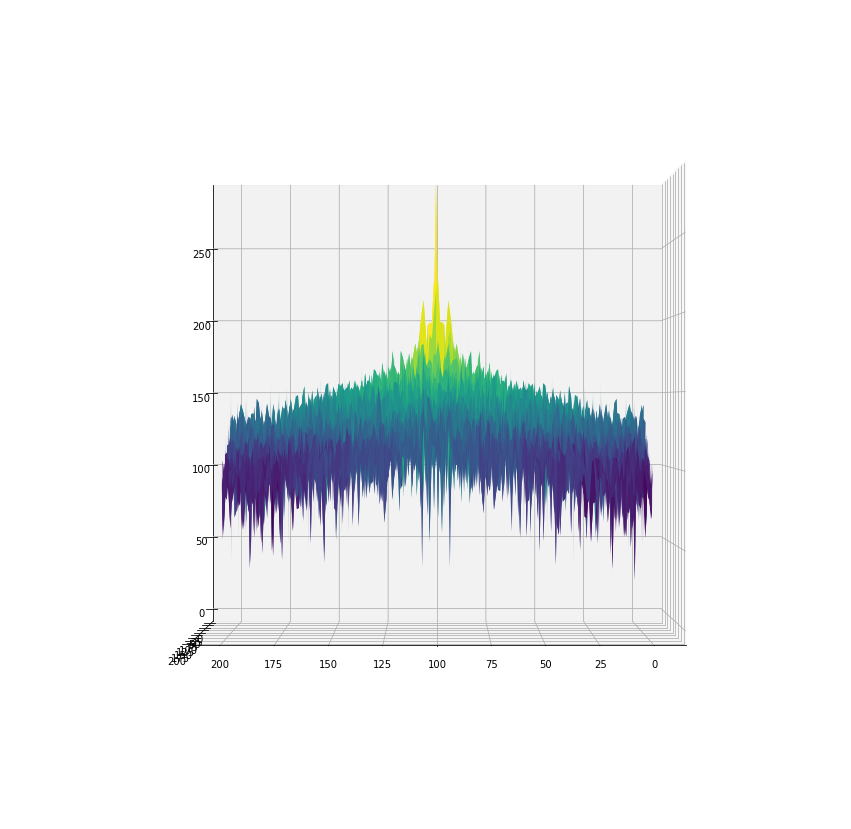

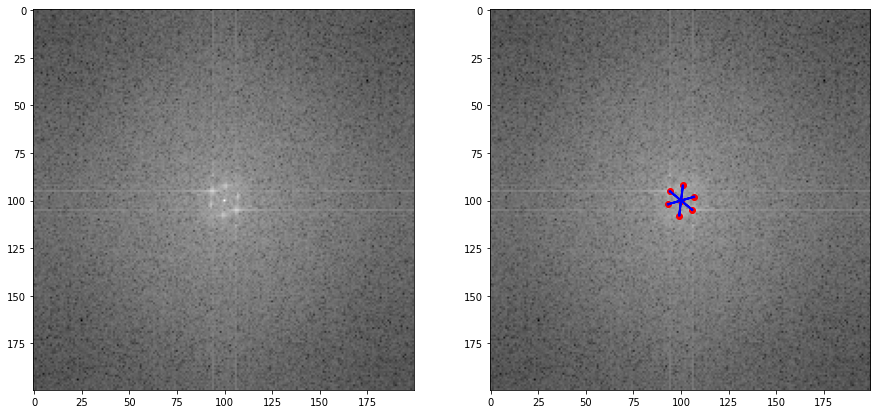

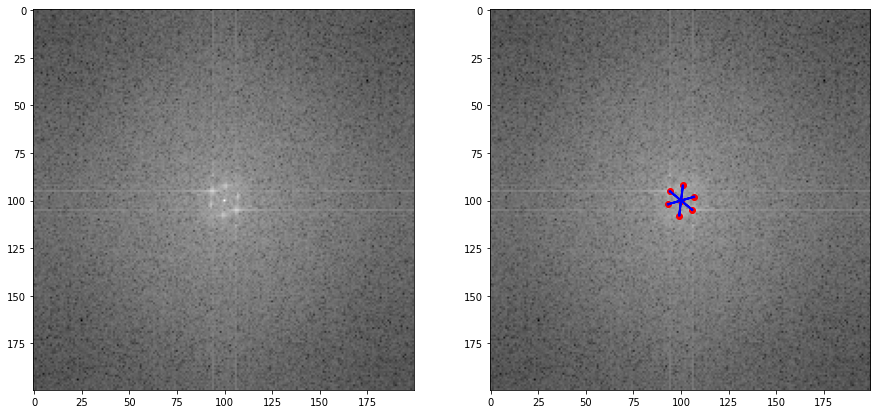

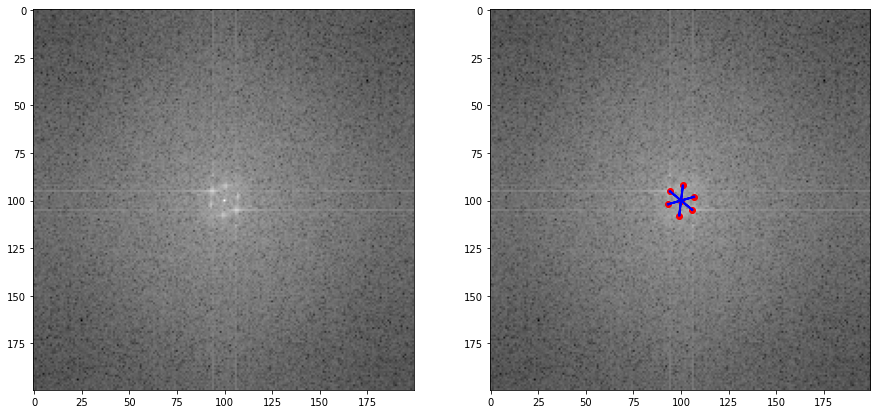

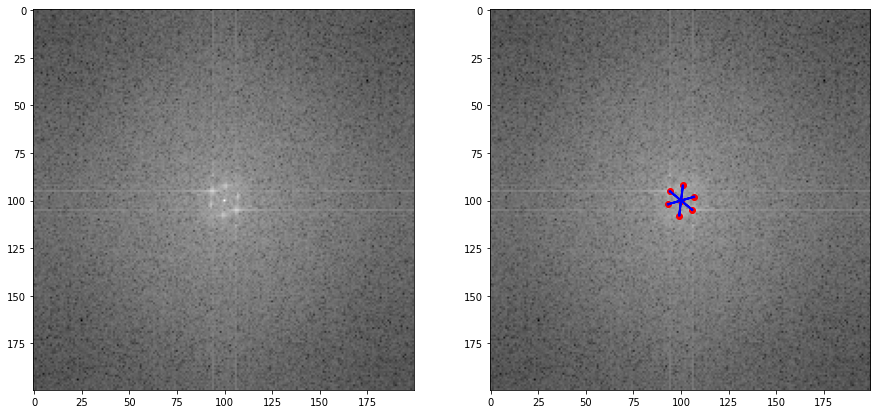

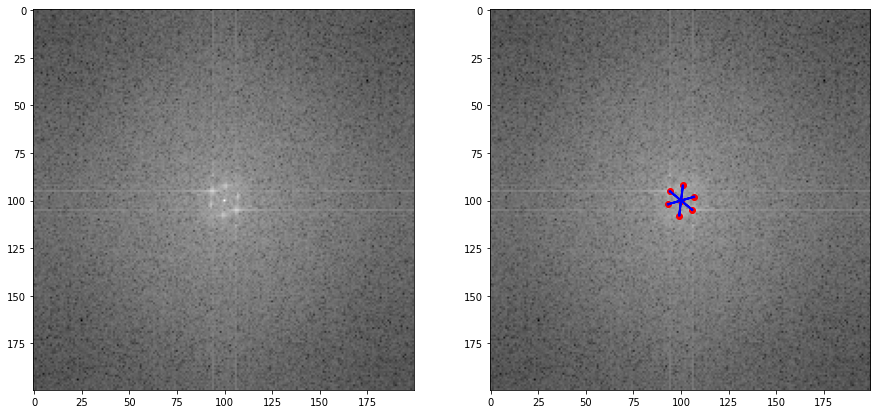

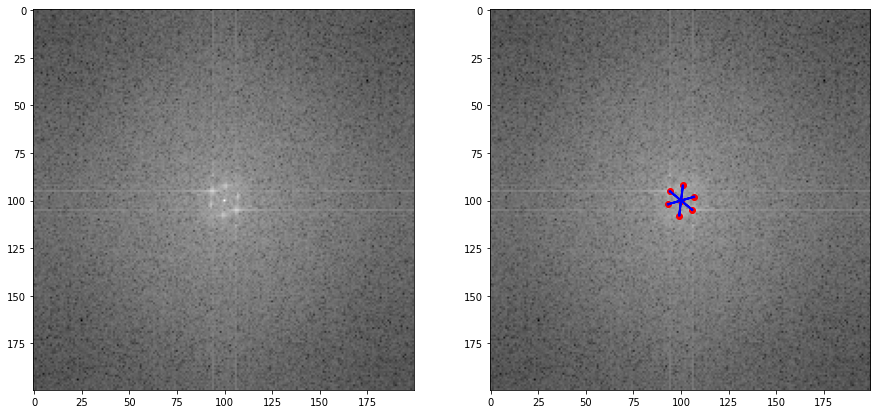

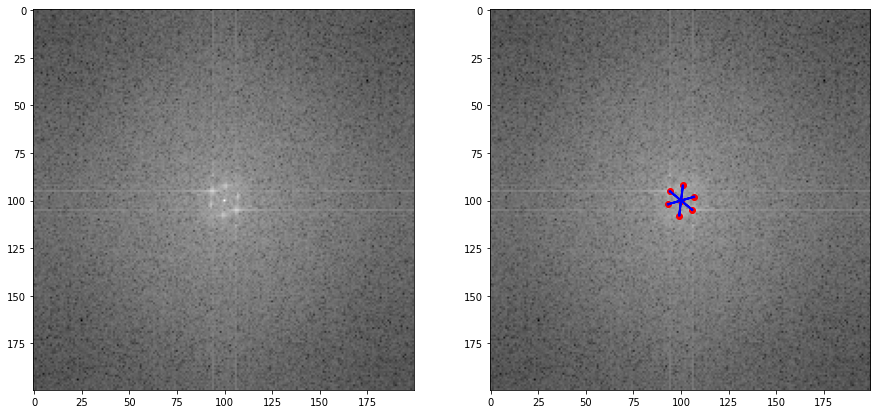

Error in callback <function flush_figures at 0x00000257C7148C10> (for post_execute):


KeyboardInterrupt: 

In [67]:
cv2.imshow(tail,imprev)
cv2.setMouseCallback(tail,mousepoint)
cv2.waitKey(0)